# Statistical Analysis of Data

## Environment Settings

An statistical Analysis of the data captured will be performed.

The environment configuration is the following:

- A rectangle area is used whose dimension is 2 x 1.5 meters. 
- A custom robot similar to an epuck was used.
- The robot starts in the middle of the arena.
- The robot moves in a random fashion way around the environment avoiding obstacles for 100 robot steps then it is moved into another random location.
- The data is not normalized in this experiment.
- The robot has 8 sensors that measure the distance between the robot and the walls.
- Some noise was introduced in the sensors measurements of the robot using the concept of [lookup tables](https://cyberbotics.com/doc/reference/distancesensor) in the Webots simulator which according to Webots documentation "The first column of the table specifies the input distances, the second column specifies the corresponding desired response values, and the third column indicates the desired standard deviation of the noise. The noise on the return value is computed according to a gaussian random number distribution whose range is calculated as a percent of the response value (two times the standard deviation is often referred to as the signal quality)". The following values were taken:

        - (0, 0, 0.2)
        - (10, 10, 0.2)
        
- The simulator runs during 25 hours of simulation (~30 minutes in fast mode).

In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install keras

import pandas as pd
import tensorflow as tf
import numpy as np
import math
from sklearn.ensemble import RandomForestRegressor
from keras import models
from keras import layers
from keras import regularizers
import matplotlib.pyplot as plt
from keras import optimizers

Using TensorFlow backend.


# First Experiment

In [2]:
csv_file = 'robot_info_dataset.csv'
df = pd.read_csv(csv_file)
df[['x', 'y', 'theta', 'sensor_1', 'sensor_2','sensor_3','sensor_4','sensor_5','sensor_6','sensor_7', 'sensor_8']].head()

,x,y,theta,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,sensor_6,sensor_7,sensor_8
0,1.462361,0.771049,231.872165,1.202188,1.698696,0.624237,0.758205,0.366404,0.497847,1.055903,0.881807
1,1.462298,0.771116,231.736292,1.593180,1.608881,1.004578,0.843159,0.496888,0.606176,0.977229,0.748680
2,1.460801,0.769242,227.883115,1.804592,1.449702,0.554147,0.711533,0.573023,0.606250,0.736492,0.669568
3,1.459133,0.767459,223.967308,1.117420,1.530710,0.639495,0.761801,0.445334,0.416549,0.820012,0.963871
4,1.457312,0.765772,220.012963,1.983638,1.704119,0.570267,0.745675,0.500298,0.461050,1.107678,0.704647


## Data pre-processing

The data collected 1125965 samples.

In [5]:
df = df[:1125965]
df.shape

(1125965, 23)

In [6]:
df.shape

(1125965, 23)

The data set contains some null values so they should be deleted from the samples.

In [7]:
df = df.dropna()

## Input and output variables

The data will be split into training, testing and validation sets. 60% of the data will be used for training, 20% for training and 20% of validation.

In [8]:

# train size
test_size_percentage = .2
train_size_percentage = .8
ds_size = df.shape[0]
train_size = int(train_size_percentage * ds_size)
test_size = int(test_size_percentage * ds_size)

# shuffle dataset
sampled_df = df.sample(frac=1)

# separate inputs from outputs
inputs = sampled_df[['x', 'y', 'theta']]
targets = sampled_df[['sensor_1', 'sensor_2', 'sensor_3', 'sensor_4', 'sensor_5', 'sensor_6', 'sensor_7', 'sensor_8']]

# train
train_inputs = inputs[:train_size]
train_targets = targets[:train_size]

# test
test_inputs = inputs[train_size:]
test_targets = targets[train_size:]

inputs.head()

,x,y,theta
1008948,0.553284,0.355467,283.333417
319647,0.847426,0.410830,100.049710
589837,0.796169,0.586912,278.116270
128988,1.791800,0.566242,209.941314
316046,0.838809,1.307713,344.379752


## Neural Network


As input the neural network receives the x, y coordinates and rotation angle $\theta$. The output are the sensor measurements. One model per sensor will be created.

In [9]:

def get_model():
    # neural network with a 10-neuron hidden layer
    model = models.Sequential()
    model.add(layers.Dense(16, activation='relu', input_shape=(3,)))
#     model.add(layers.Dropout(0.5))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(16, activation='relu'))
    model.add(layers.Dense(1))
    
#     rmsprop = optimizers.RMSprop(learning_rate=0.01)
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
              
    return model

In [11]:
def k_fold(sensor_number, num_epochs=10, k=5):
    num_val_samples = len(train_inputs) // k
    validation_scores = []
    histories = []
    nmse = []

    for i in range(k):
        print('processing fold #', i)
        val_data = train_inputs[i * num_val_samples: (i + 1) * num_val_samples]
        val_targets = train_targets[[sensor_number]][i * num_val_samples: (i + 1) * num_val_samples]

        partial_train_data = np.concatenate(
            [train_inputs[:i * num_val_samples],
             train_inputs[(i + 1) * num_val_samples:]], axis=0)
        partial_train_targets = np.concatenate(
            [train_targets[[sensor_number]][:i * num_val_samples],
             train_targets[[sensor_number]][(i + 1) * num_val_samples:]], axis=0)


        model = get_model()

        history = model.fit(partial_train_data, partial_train_targets,
                            validation_data=(val_data, val_targets),
                            epochs=num_epochs, batch_size=64, verbose=1)
        histories.append(history.history)

        predictions_targets = model.predict(val_data)
        nmse.append(np.mean((predictions_targets - val_targets)**2)/np.var(val_targets))
        
    return histories, nmse


In [13]:
histories, nmse = k_fold('sensor_3', 50, 3)

processing fold # 0
Train on 600514 samples, validate on 300257 samples
Epoch 1/50
600514/600514 [==============================] - 14s 24us/step - loss: 0.4882 - mae: 0.3625 - val_loss: 0.1258 - val_mae: 0.2739
Epoch 2/50
600514/600514 [==============================] - 13s 21us/step - loss: 0.0731 - mae: 0.1978 - val_loss: 0.0851 - val_mae: 0.2155
Epoch 3/50
600514/600514 [==============================] - 13s 21us/step - loss: 0.0577 - mae: 0.1736 - val_loss: 0.0747 - val_mae: 0.2057
Epoch 4/50
600514/600514 [==============================] - 13s 21us/step - loss: 0.0518 - mae: 0.1635 - val_loss: 0.0656 - val_mae: 0.1993
Epoch 5/50
600514/600514 [==============================] - 13s 21us/step - loss: 0.0490 - mae: 0.1587 - val_loss: 0.0842 - val_mae: 0.2190
Epoch 6/50
600514/600514 [==============================] - 12s 21us/step - loss: 0.0470 - mae: 0.1549 - val_loss: 0.0656 - val_mae: 0.1907
Epoch 7/50
600514/600514 [==============================] - 12s 21us/step - loss: 0.0458

600514/600514 [==============================] - 16s 27us/step - loss: 0.0446 - mae: 0.1508 - val_loss: 0.1234 - val_mae: 0.2689
Epoch 9/50
600514/600514 [==============================] - 14s 23us/step - loss: 0.0440 - mae: 0.1495 - val_loss: 0.0463 - val_mae: 0.1574
Epoch 10/50
600514/600514 [==============================] - 14s 24us/step - loss: 0.0435 - mae: 0.1486 - val_loss: 0.0425 - val_mae: 0.1463
Epoch 11/50
600514/600514 [==============================] - 14s 24us/step - loss: 0.0429 - mae: 0.1475 - val_loss: 0.0548 - val_mae: 0.1724
Epoch 12/50
600514/600514 [==============================] - 14s 23us/step - loss: 0.0427 - mae: 0.1469 - val_loss: 0.0501 - val_mae: 0.1601
Epoch 13/50
600514/600514 [==============================] - 13s 22us/step - loss: 0.0425 - mae: 0.1465 - val_loss: 0.0683 - val_mae: 0.1915
Epoch 14/50
600514/600514 [==============================] - 16s 27us/step - loss: 0.0423 - mae: 0.1459 - val_loss: 0.0430 - val_mae: 0.1480
Epoch 15/50
600514/600514 

600514/600514 [==============================] - 15s 24us/step - loss: 0.0422 - mae: 0.1455 - val_loss: 0.0425 - val_mae: 0.1497
Epoch 16/50
600514/600514 [==============================] - 17s 28us/step - loss: 0.0421 - mae: 0.1452 - val_loss: 0.0699 - val_mae: 0.1893
Epoch 17/50
600514/600514 [==============================] - 14s 23us/step - loss: 0.0419 - mae: 0.1449 - val_loss: 0.0562 - val_mae: 0.1726
Epoch 18/50
600514/600514 [==============================] - 15s 24us/step - loss: 0.0418 - mae: 0.1446 - val_loss: 0.0417 - val_mae: 0.1456
Epoch 19/50
600514/600514 [==============================] - 15s 25us/step - loss: 0.0417 - mae: 0.1443 - val_loss: 0.0610 - val_mae: 0.1808
Epoch 20/50
600514/600514 [==============================] - 14s 24us/step - loss: 0.0416 - mae: 0.1440 - val_loss: 0.0412 - val_mae: 0.1438
Epoch 21/50
600514/600514 [==============================] - 13s 22us/step - loss: 0.0416 - mae: 0.1441 - val_loss: 0.0450 - val_mae: 0.1501
Epoch 22/50
600514/600514

NMSE: 
0.18207304609475203


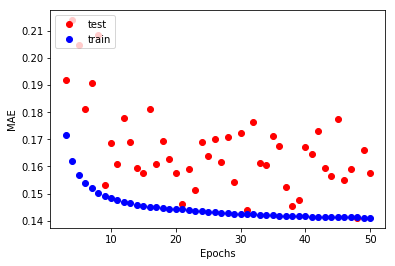

In [14]:
print("NMSE: ")
print(np.mean(nmse))

num_epochs = 50
val_mae_history = [np.mean([x['val_mae'][i] for x in histories]) for i in range(num_epochs)]
mae_history = [np.mean([x['mae'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(3, len(val_mae_history) + 1), val_mae_history[2:], 'ro')
plt.plot(range(3, len(mae_history) + 1), mae_history[2:], 'bo')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend(['test', 'train'], loc='upper left')
plt.show()


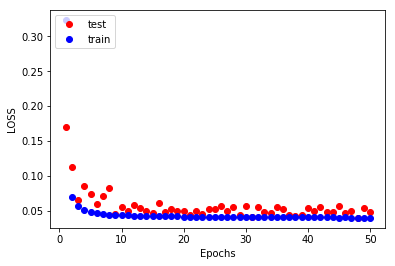

In [15]:
val_loss_history = [np.mean([x['val_loss'][i] for x in histories]) for i in range(num_epochs)]
loss_history = [np.mean([x['loss'][i] for x in histories]) for i in range(num_epochs)]
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history, 'ro')
plt.plot(range(1, len(loss_history) + 1), loss_history, 'bo')
plt.xlabel('Epochs')
plt.ylabel('LOSS')
plt.legend(['test', 'train'], loc='upper left')
plt.show()

In [16]:
model = get_model()

history = model.fit(inputs, targets[['sensor_5']], epochs=20, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_5.h5")

Epoch 1/20
1125964/1125964 [==============================] - 23s 20us/step - loss: 0.1848 - mae: 0.2754
Epoch 2/20
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.0544 - mae: 0.1708
Epoch 3/20
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.0469 - mae: 0.1571
Epoch 4/20
1125964/1125964 [==============================] - 23s 20us/step - loss: 0.0439 - mae: 0.1511
Epoch 5/20
1125964/1125964 [==============================] - 21s 19us/step - loss: 0.0422 - mae: 0.1476
Epoch 6/20
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.0405 - mae: 0.1442
Epoch 7/20
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.0398 - mae: 0.1427
Epoch 8/20
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.0392 - mae: 0.1416
Epoch 9/20
1125964/1125964 [==============================] - 23s 20us/step - loss: 0.0389 - mae: 0.1407
Epoch 10/20
1125964/1125964 [==========================

In [17]:
model = get_model()

history = model.fit(inputs, targets[['sensor_6']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_6.h5")

Epoch 1/50
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.2042 - mae: 0.2686
Epoch 2/50
1125964/1125964 [==============================] - 23s 21us/step - loss: 0.0521 - mae: 0.1663
Epoch 3/50
1125964/1125964 [==============================] - 23s 20us/step - loss: 0.0463 - mae: 0.1552
Epoch 4/50
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.0441 - mae: 0.1507
Epoch 5/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0427 - mae: 0.1479
Epoch 6/50
1125964/1125964 [==============================] - 21s 19us/step - loss: 0.0416 - mae: 0.1455
Epoch 7/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0410 - mae: 0.1441
Epoch 8/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0404 - mae: 0.1429
Epoch 9/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0400 - mae: 0.1421
Epoch 10/50
1125964/1125964 [==========================

In [18]:
model = get_model()

history = model.fit(inputs, targets[['sensor_7']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_7.h5")

Epoch 1/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1466 - mae: 0.2521
Epoch 2/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0635 - mae: 0.1742
Epoch 3/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0551 - mae: 0.1593
Epoch 4/50
1125964/1125964 [==============================] - 20s 17us/step - loss: 0.0523 - mae: 0.1538
Epoch 5/50
1125964/1125964 [==============================] - 20s 17us/step - loss: 0.0512 - mae: 0.1514
Epoch 6/50
1125964/1125964 [==============================] - 21s 18us/step - loss: 0.0504 - mae: 0.1498
Epoch 7/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.0498 - mae: 0.1485
Epoch 8/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0494 - mae: 0.1476
Epoch 9/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0490 - mae: 0.1468
Epoch 10/50
1125964/1125964 [==========================

In [19]:
model = get_model()
history = model.fit(inputs, targets[['sensor_8']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_8.h5")

Epoch 1/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.3434 - mae: 0.3078
Epoch 2/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1276 - mae: 0.1863
Epoch 3/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1198 - mae: 0.1742
Epoch 4/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1173 - mae: 0.1698
Epoch 5/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1161 - mae: 0.1677
Epoch 6/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1156 - mae: 0.1668
Epoch 7/50
1125964/1125964 [==============================] - 21s 19us/step - loss: 0.1151 - mae: 0.1661
Epoch 8/50
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.1147 - mae: 0.1651
Epoch 9/50
1125964/1125964 [==============================] - 20s 18us/step - loss: 0.1147 - mae: 0.1648
Epoch 10/50
1125964/1125964 [==========================

In [20]:
model = get_model()

history = model.fit(inputs, targets[['sensor_1']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_1.h5")

Epoch 1/50
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.2831 - mae: 0.2930
Epoch 2/50
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.1330 - mae: 0.1914
Epoch 3/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.1256 - mae: 0.1796
Epoch 4/50
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.1223 - mae: 0.1743
Epoch 5/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.1206 - mae: 0.1713
Epoch 6/50
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.1194 - mae: 0.1691
Epoch 7/50
1125964/1125964 [==============================] - 23s 21us/step - loss: 0.1185 - mae: 0.1676
Epoch 8/50
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.1177 - mae: 0.1663
Epoch 9/50
1125964/1125964 [==============================] - 23s 21us/step - loss: 0.1173 - mae: 0.1655
Epoch 10/50
1125964/1125964 [==========================

In [21]:
model = get_model()

history = model.fit(inputs, targets[['sensor_2']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_2.h5")

Epoch 1/50
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.1558 - mae: 0.2491
Epoch 2/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0630 - mae: 0.1708
Epoch 3/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0579 - mae: 0.1613
Epoch 4/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0557 - mae: 0.1571
Epoch 5/50
1125964/1125964 [==============================] - 23s 21us/step - loss: 0.0545 - mae: 0.1547
Epoch 6/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0538 - mae: 0.1533
Epoch 7/50
1125964/1125964 [==============================] - 29s 25us/step - loss: 0.0534 - mae: 0.1523
Epoch 8/50
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.0529 - mae: 0.1514
Epoch 9/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0526 - mae: 0.1508 0s -
Epoch 10/50
1125964/1125964 [=====================

In [22]:
model = get_model()

history = model.fit(inputs, targets[['sensor_3']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_3.h5")

Epoch 1/50
1125964/1125964 [==============================] - 27s 24us/step - loss: 0.1365 - mae: 0.2589
Epoch 2/50
1125964/1125964 [==============================] - 25s 23us/step - loss: 0.0550 - mae: 0.1703
Epoch 3/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0487 - mae: 0.1587
Epoch 4/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0460 - mae: 0.1535
Epoch 5/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0445 - mae: 0.1503
Epoch 6/50
1125964/1125964 [==============================] - 24s 21us/step - loss: 0.0436 - mae: 0.1485
Epoch 7/50
1125964/1125964 [==============================] - 24s 22us/step - loss: 0.0430 - mae: 0.1472
Epoch 8/50
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.0424 - mae: 0.1459
Epoch 9/50
1125964/1125964 [==============================] - 26s 23us/step - loss: 0.0419 - mae: 0.1449
Epoch 10/50
1125964/1125964 [==========================

In [23]:
model = get_model()

history = model.fit(inputs, targets[['sensor_4']], epochs=50, batch_size=64, verbose=1)
history.history['mae']
model.save("nn_sensor_4.h5")

Epoch 1/50
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.1025 - mae: 0.2247
Epoch 2/50
1125964/1125964 [==============================] - 22s 19us/step - loss: 0.0518 - mae: 0.1647
Epoch 3/50
1125964/1125964 [==============================] - 22s 20us/step - loss: 0.0460 - mae: 0.1539
Epoch 4/50
1125964/1125964 [==============================] - 22s 19us/step - loss: 0.0433 - mae: 0.1485
Epoch 5/50
1125964/1125964 [==============================] - 22s 19us/step - loss: 0.0420 - mae: 0.1459
Epoch 6/50
1125964/1125964 [==============================] - 22s 19us/step - loss: 0.0413 - mae: 0.1444
Epoch 7/50
1125964/1125964 [==============================] - 22s 19us/step - loss: 0.0407 - mae: 0.1432
Epoch 8/50
1125964/1125964 [==============================] - 23s 21us/step - loss: 0.0403 - mae: 0.1423
Epoch 9/50
1125964/1125964 [==============================] - 25s 22us/step - loss: 0.0400 - mae: 0.1416
Epoch 10/50
1125964/1125964 [==========================